In [2]:
# ## SMA Crossover Backtest with Dynamic Percent‐of‐Portfolio Sizing

# %%
%matplotlib inline

import os
import datetime

import backtrader as bt
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# 1) Strategy definition with a `percent` param
class SmaCross(bt.Strategy):
    params = dict(
        pfast=10,        # fast MA period
        pslow=30,        # slow MA period
        percent=0.3      # fraction of portfolio to invest (0.3=30%)
    )

    def __init__(self):
        sma_fast = bt.ind.SMA(period=self.p.pfast)
        sma_slow = bt.ind.SMA(period=self.p.pslow)
        self.crossover = bt.ind.CrossOver(sma_fast, sma_slow)

    def next(self):
        price = self.data.close[0]
        equity = self.broker.getvalue()
        # compute maximum shares to buy for the given percent
        size = int((equity * self.p.percent) / price)

        if not self.position and self.crossover > 0:
            if size > 0:
                self.buy(size=size)
                print(f"BUY {size} @ {price:.2f} (alloc {self.p.percent*100:.0f}% = {equity*self.p.percent:.2f})")
        elif self.position and self.crossover < 0:
            # exit full position
            self.sell(size=self.position.size)
            print(f"SELL {self.position.size} @ {price:.2f}")

# 2) Configuration
CSV_FILE = 'tsla.csv'
DOWNLOAD = True     # set True to refresh CSV
START = datetime.datetime(2020, 1, 1)
END   = datetime.datetime(2025, 5, 23)

# Change this to 0.3 for 30%, 0.5 for 50%, etc.
PCT_TO_INVEST = 0.95

# 3) Fetch or load TSLA data
if DOWNLOAD or not os.path.exists(CSV_FILE):
    print(f"Downloading TSLA data {START.date()} → {END.date()}…")
    df = yf.download(
        'TSLA',
        start=START, end=END,
        auto_adjust=True,
        progress=False,
        group_by='column',
        multi_level_index=False
    )
    df.to_csv(CSV_FILE)
    print(f"Saved to {CSV_FILE}")
else:
    print(f"Loading data from {CSV_FILE}")
    df = pd.read_csv(CSV_FILE, parse_dates=True, index_col=0)

# 4) Set up Cerebro
cerebro = bt.Cerebro()
# pass our percent into the strategy
cerebro.addstrategy(SmaCross, percent=PCT_TO_INVEST)

datafeed = bt.feeds.PandasData(dataname=df)
cerebro.adddata(datafeed)

cerebro.broker.setcash(100000)           # start with 100k
cerebro.broker.setcommission(0.001)      # 0.1% commission

# 5) Run
print(f"Starting Portfolio Value: {cerebro.broker.getvalue():,.2f}")
cerebro.run()
print(f"Final   Portfolio Value: {cerebro.broker.getvalue():,.2f}")

# 6) Plot inline
cerebro.plot()
plt.show()


Saved to tsla.csv
Starting Portfolio Value: 100,000.00
BUY 1952 @ 48.66 (alloc 95% = 95000.00)
SELL 1952 @ 138.36
BUY 1885 @ 141.97 (alloc 95% = 267703.53)
SELL 1885 @ 136.94
BUY 1561 @ 162.21 (alloc 95% = 253337.52)
SELL 1561 @ 266.05
BUY 1690 @ 233.99 (alloc 95% = 395516.37)
SELL 1690 @ 224.12
BUY 1796 @ 205.53 (alloc 95% = 369198.15)
SELL 1796 @ 214.93
BUY 1638 @ 236.56 (alloc 95% = 387607.85)
SELL 1638 @ 336.34
BUY 1388 @ 399.93 (alloc 95% = 555374.54)
SELL 1388 @ 310.00
BUY 1301 @ 333.04 (alloc 95% = 433424.37)
SELL 1301 @ 292.14
BUY 1659 @ 233.07 (alloc 95% = 386846.25)
SELL 1659 @ 234.34
BUY 1660 @ 238.31 (alloc 95% = 395670.62)
SELL 1660 @ 277.16
BUY 1515 @ 303.35 (alloc 95% = 459616.29)
SELL 1515 @ 268.21
BUY 2838 @ 144.43 (alloc 95% = 409953.18)
BUY 1976 @ 207.46 (alloc 95% = 409953.18)
SELL 1976 @ 187.04
BUY 2138 @ 180.14 (alloc 95% = 385273.50)
SELL 2138 @ 261.07
BUY 2129 @ 251.92 (alloc 95% = 536455.87)
SELL 2129 @ 251.60
BUY 2096 @ 258.87 (alloc 95% = 542617.19)
SELL 2096

<IPython.core.display.Javascript object>

In [3]:
import datetime
import matplotlib.pyplot as plt

# … after you’ve run cerebro …
fig_lists = cerebro.plot()  # list-of-lists of Figure objects

# Timestamp for filenames
ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

for outer_i, fig_list in enumerate(fig_lists):
    for inner_i, fig in enumerate(fig_list):
        # Optionally resize the figure (width, height in inches)
        fig.set_size_inches(12, 8)
        
        # Build filename
        fn = f'sma_crossover_{ts}_{outer_i}_{inner_i}.png'
        
        # Save at 300 dpi for high resolution
        fig.savefig(fn, bbox_inches='tight', dpi=300)
        print(f"Saved high-res plot to {fn}")


<IPython.core.display.Javascript object>

Saved high-res plot to sma_crossover_20250526_143034_0_0.png


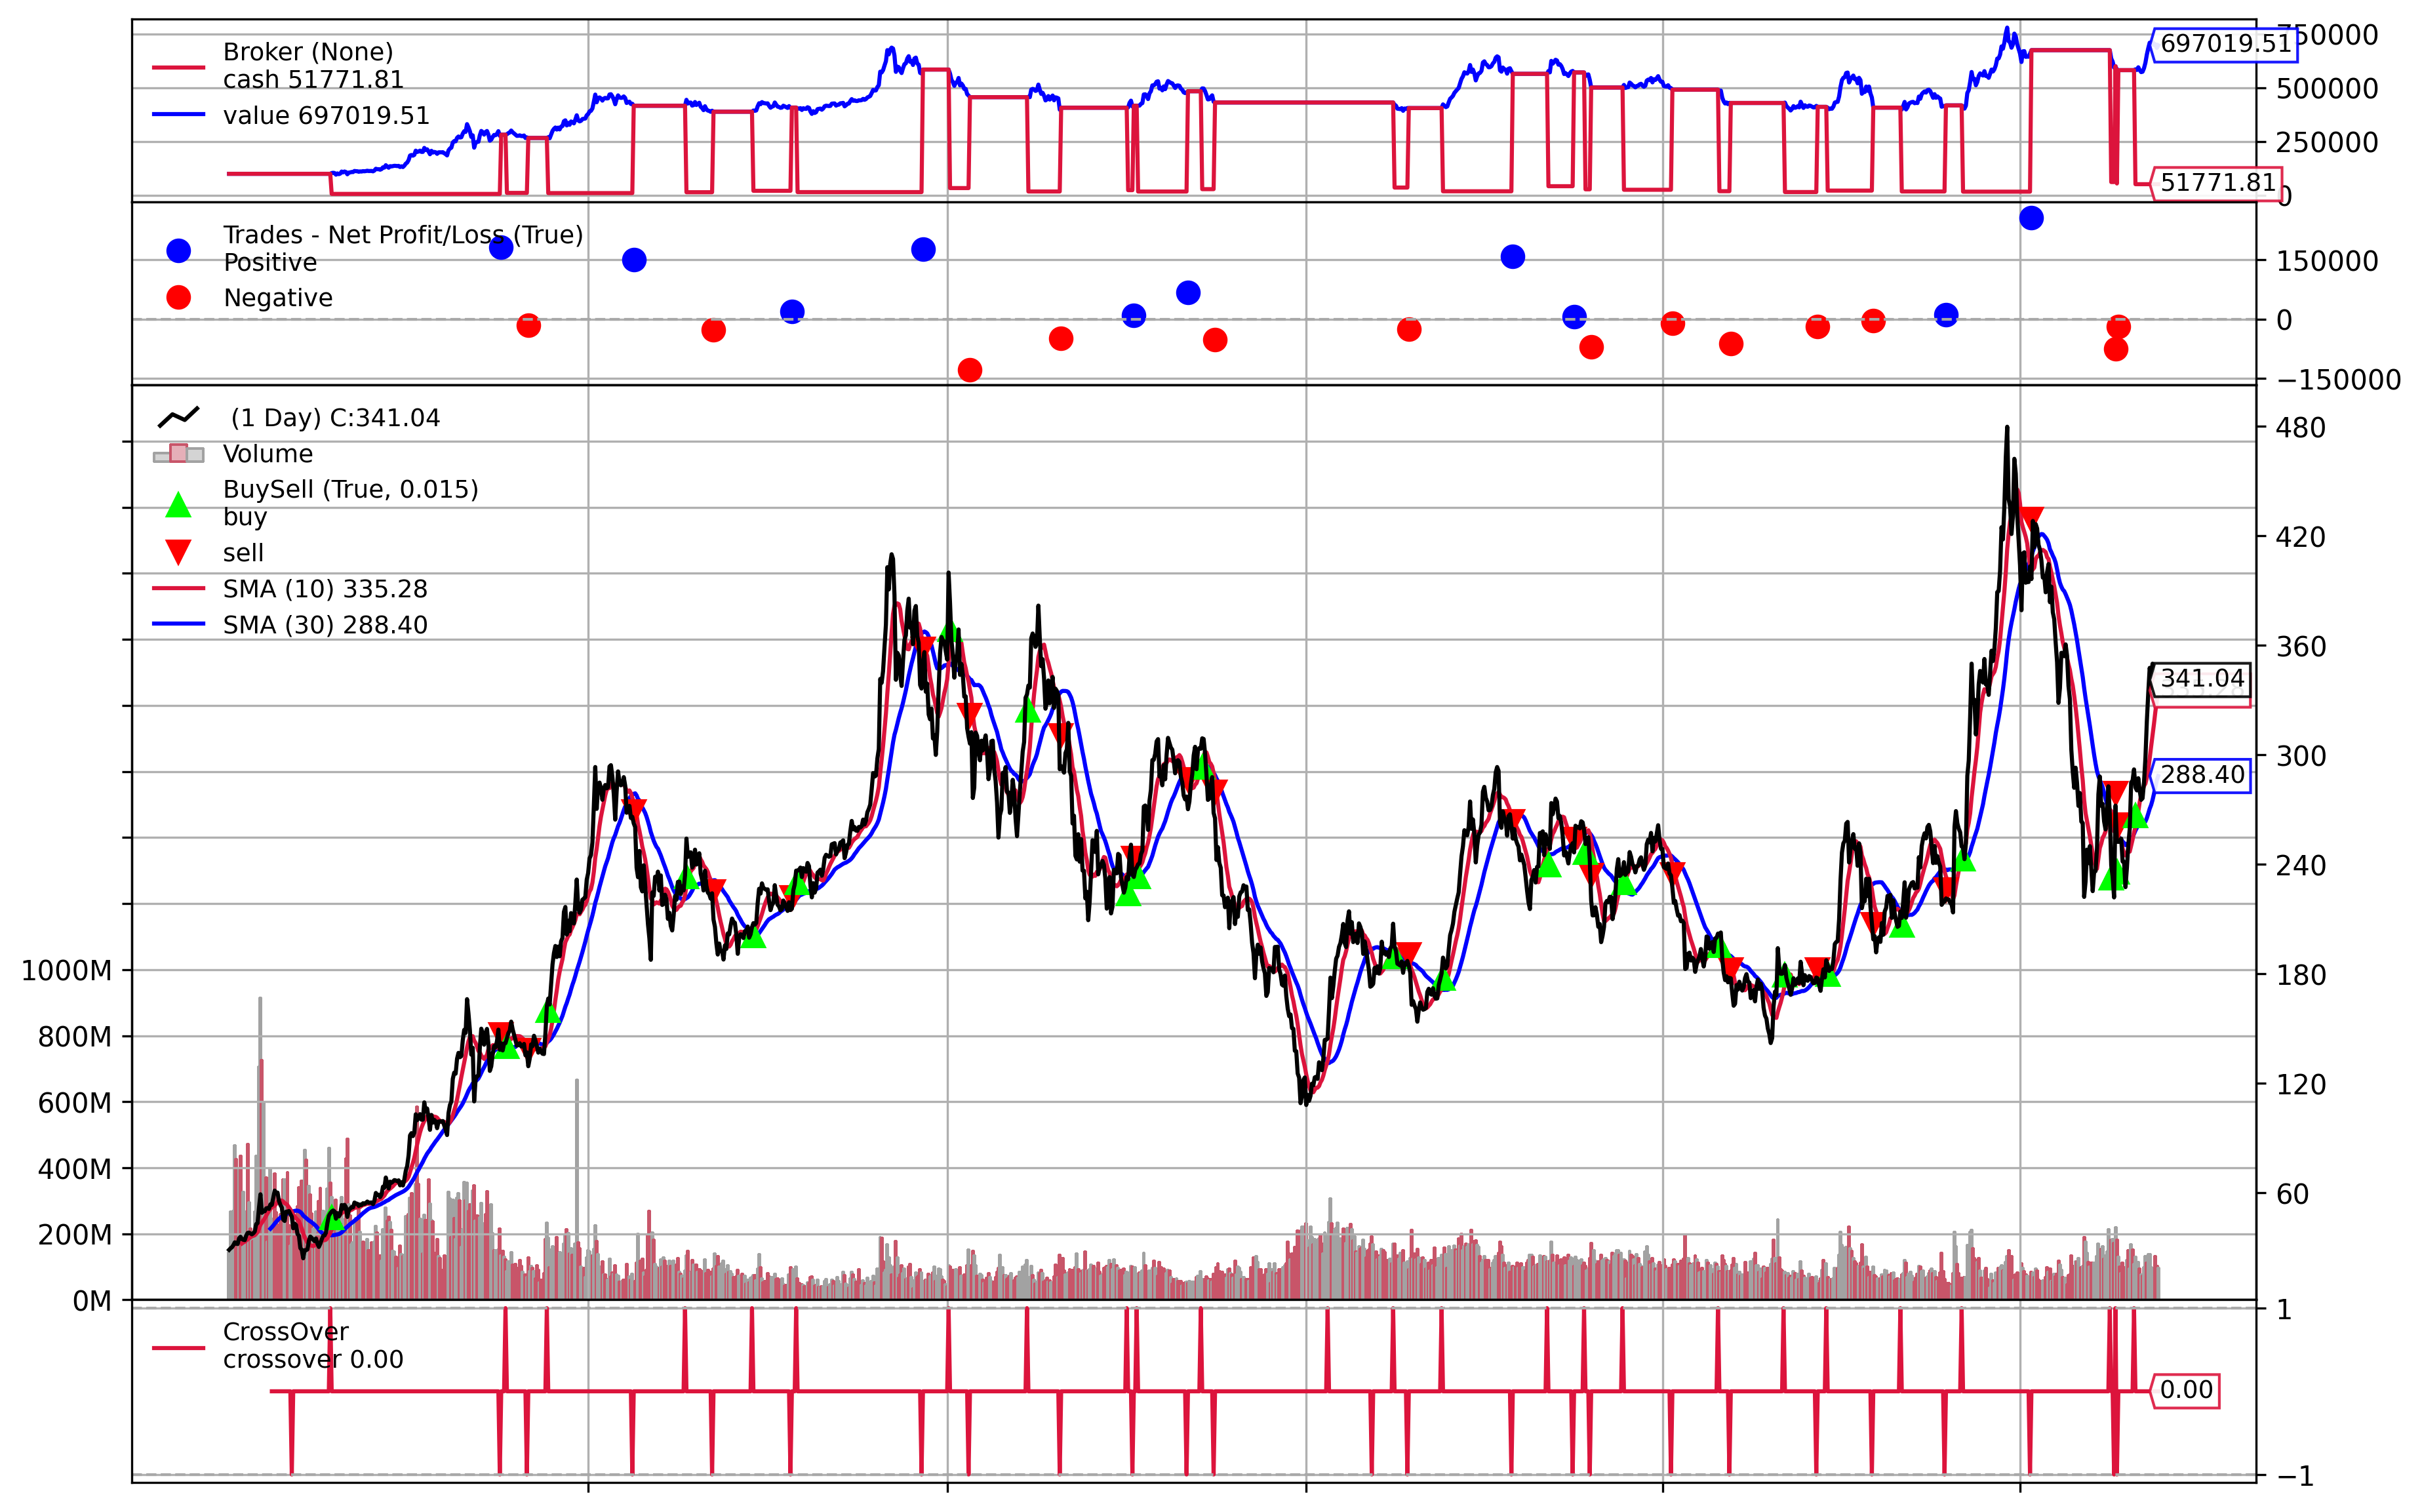

In [4]:
from IPython.display import Image, display

# display each saved PNG inline
for outer_i, fig_list in enumerate(fig_lists):
    for inner_i, fig in enumerate(fig_list):
        fn = f'sma_crossover_{ts}_{outer_i}_{inner_i}.png'
        display(Image(filename=fn))
